# Train LSTM network using Keypoint Features

## Import libraries

In [3]:
# Basic functions
import os
import torch
import numpy as np
import re
from importlib import reload

# Training/Test Set Creation - to use later
from sklearn.model_selection import StratifiedShuffleSplit

# Dataset Creation
from collections import Counter
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize

# Model Training and Definition
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import trainutils
import vidutils

## Create Training and Test Sets

### Define classes and preview

In [4]:
# Define label dictionary - 20 classes
syncs = [  "0-100 ms", "101-200 ms", "201-300 ms", "301-400 ms", "401-500 ms", 
         "501-600 ms", "601-700 ms", "701-800 ms", "801-900 ms", "901-1000 ms" ]
sync_dict = {}

count = 0
for sync_val in syncs:
    sync_dict[sync_val] = count
    count += 1

# preview dictionary
sync_dict

{'0-100 ms': 0,
 '101-200 ms': 1,
 '201-300 ms': 2,
 '301-400 ms': 3,
 '401-500 ms': 4,
 '501-600 ms': 5,
 '601-700 ms': 6,
 '701-800 ms': 7,
 '801-900 ms': 8,
 '901-1000 ms': 9}

### Load training data
Choose between using synthetic data, real data or both. 

Usage example: If only real data is to be used, set `real_data` to `True` and `syn_data` to `False`.

In [27]:
### --------------------------------------------
# Choose datasets to use
real_data = True
syn_data = False
### --------------------------------------------

X_paths = [] # paths of segment folders
y = [] # designated label

if real_data:
    # Specify directories
    frame_folder = "./data/frames"
    
    # Construct X = folder names, y = the label
    vf_list = []
    for f in os.listdir(frame_folder):
        if not f.startswith('.'):
            vf_list.append(f)
    
    for vf_folder in vf_list:
        # Create path to video
        vf_path = os.path.join(frame_folder, vf_folder)
        print("Current Video: "+ vf_folder)

        # Get individual segment folder
        segfolder_list = os.listdir(vf_path)

        # Check every segment folder
        for seg_folder in segfolder_list:

            if not seg_folder.startswith('.'):
                x_path = os.path.join(vf_path, seg_folder)
                X_paths.append(x_path + '/features.npz')

                # Extract class label from folder name
                label = int(seg_folder.split("_")[2])
                y.append(label)
        
if syn_data:
    # define synthetic data directory
    output_dir = './synthetic_data/output'
    output_list = os.listdir(output_dir)

    for output_folder in output_list:
        if output_folder.startswith('vid'):
            x_path = output_dir + '/' + output_folder
            X_paths.append(x_path)

            # Extract class label from folder name
            params = re.findall(r'\d+', output_folder)
            label = int( (int(params[3]) - 1) / 100)
            y.append(label)

Current Video: video3
Current Video: video4
Current Video: video2
Current Video: video1


In [28]:
# Preview Data distribution
from collections import Counter
Counter(y)

Counter({3: 50, 4: 50, 6: 48, 1: 54, 5: 51, 8: 52, 2: 49, 9: 52, 0: 48, 7: 50})

In [29]:
# Split into training and test sets
splitter = StratifiedShuffleSplit(n_splits = 2, test_size = 0.1, random_state = 0)
train_set, test_set = next(splitter.split(X_paths, y))

# Training Set
train_X_paths = [X_paths[i] for i in train_set]
train_ys = [y[i] for i in train_set]
print("Training Set: ({0},{1})".format(len(train_X_paths), len(train_ys)))

# Test Set
test_X_paths = [X_paths[i] for i in test_set]
test_ys = [y[i] for i in test_set]
print("Test Set: ({0},{1})".format(len(test_X_paths), len(test_ys)))

Training Set: (453,453)
Test Set: (51,51)


### Conversion to Pytorch Dataset
Set seeds for reproducibility and produce pytorch tensor for training.

In [30]:
# Set seeds for reproducibility
np.random.seed(4139)
torch.manual_seed(4139)

Definition of dataset class and normalization function

In [31]:
# Define Dataset Class
class SyncDataset(Dataset):
    
    def __init__(self, X, y, transform=None):
        self.transform = transform
        self.X = X
        self.y = y
    
    # Returns length
    def __len__(self):
        return len(self.X)
    
    # Returns X feature array and y value
    def __getitem__(self, idx):
        
        # Load npz file
        npz_path = self.X[idx]
        data = np.load(npz_path)
        num_frames = 20
        
        # extract features (different based on synthetic or real)
        if npz_path.startswith('./data/'):
            X_feat = data['feature_array']
        else:
            X_feat = vidutils_leon.reshape_syn_features \
            (data['subset_all'][:num_frames], data['candidate_all'][:num_frames])
        
         # apply transform
        if self.transform:
            X_tensor = self.transform(X_feat).squeeze().float()
        else:
            # Convert X to tensor
            X_tensor = torch.from_numpy(X_feat).float()
        
        return X_tensor, self.y[idx] # y_tensor

# Define normalization function
class norm_with_saved(object):
    """
    Rescale each feature by subtracting mean and dividing by SD over all subjects
    IMPORTANT: Calculate saved_mean and saved_std first.
    """
    def __call__(self, sample):
        # squeeze tensor
        sample = sample.squeeze()
        # normalize
        scaled_sample = (sample - saved_mean)/saved_std
        return scaled_sample

In [32]:
# Define Transformer 
transformer = transforms.Compose([
    transforms.ToTensor() 
])

In [33]:
# Define Training Dataset 
training_dataset = SyncDataset(X = train_X_paths, y = train_ys, transform = transformer)
print(len(training_dataset))

# Define Test Dataset
testing_dataset = SyncDataset(X = test_X_paths, y = test_ys, transform = transformer)
print(len(testing_dataset))

453
51


In [34]:
# Grab a row to see contents
sample_X, sample_y = training_dataset[2]
sample_X.shape, sample_y

(torch.Size([20, 168]), 6)

### Define Data Loader  

Data Loader for extracting batches from the Pytorch Dataset during model training

In [35]:
def batch_collater(batch):
    X_batch, y_batch = list(zip(*batch))
    
    # Separate batch into X and y
    X_batch = [x for x in X_batch if len(x) > 0]
    y_batch = [torch.tensor(y) for y, x in zip(y_batch, X_batch) if len(x) > 0]
    
    # Convert into tensors
    X_tensor = torch.stack(X_batch)
    y_tensor = torch.stack(y_batch).long()
    
    return X_tensor, y_tensor

In [36]:
# Specify batch size
batch_size = 30

training_loader = DataLoader(training_dataset, batch_size = batch_size, shuffle=True, collate_fn=batch_collater)
testing_loader = DataLoader(testing_dataset, batch_size = batch_size, shuffle=True, collate_fn=batch_collater)

In [37]:
for xb, yb in training_loader:
    print(xb.shape, yb.shape)
    break

for xb, yb in testing_loader:
    print(xb.shape, yb.shape)
    break

torch.Size([30, 20, 168]) torch.Size([30])
torch.Size([30, 20, 168]) torch.Size([30])


## Model Definition 
Define LSTM architecture and optimizer settings.

In [38]:
class SyncRNN(nn.Module):
    
    def __init__(self, params_model):
        
        super(SyncRNN, self).__init__()
        
        # Import Model Parameters
        num_classes = params_model["num_classes"]
        dr_rate = params_model["dr_rate"] # dropout rate
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
        num_features = 168
        
        # Define Model Structure
        self.dropout = nn.Dropout(dr_rate) # - do we need this?
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)
        
    def forward(self, x):
        
        # batch count, frame count, feature size
        batch_count, frame_count, feature_size = x.shape
        frame_idx = 0
        
        # Reshape the frame
        shaped_frame = x[:, frame_idx].view(batch_count, 1, feature_size)
        
        # Feed the first frame into the rnn
        output, (hn, cn) = self.rnn(shaped_frame)
        
        # Feed the rest of the frames 
        for frame_idx in range(1, frame_count):
            shaped_frame = x[:, frame_idx].view(batch_count, 1, feature_size)
            output, (hn, cn) = self.rnn(shaped_frame, (hn, cn))
        
        output = self.fc1(output)
        return output     

Choose between regression or classification model and select type of loss.

Modify `loss_fn` and `weight_path` to choose the most appropriate loss function and save the results in a directory of your choice.

In [46]:
### --------------------------------------------
# Choose whether to use classification model or regression model
classif_model = True
reg_model = False
### --------------------------------------------
assert (classif_model != reg_model), print("ERROR: Choose one model only")

# Define Loss Function
if classif_model:
    loss_fn = nn.CrossEntropyLoss(reduction="sum")
    weight_path = "./models/weights_leon_test.pt"
    num_class = 10

if reg_model:
    # choose between L1 and MSE
    #loss_fn = nn.L1Loss(reduction="sum")
    loss_fn = nn.MSELoss(reduction="sum")
    weight_path = "./models/weights_real_mse.pt"
    num_class = 1


# RNN Model Parameters
model_params = {
    "num_classes": num_class,
    "dr_rate": 0.1,
    "rnn_num_layers": 1,
    "rnn_hidden_size": 500,
}
model = SyncRNN(model_params)

In [47]:
# Test Model with dummy input
with torch.no_grad():
    x = torch.zeros(1, 50, 168)
    y = model(x)
    print(y.shape) # should be [1,1,10] for classification and [1,1,1] for regression

torch.Size([1, 1, 10])


In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Print Model Params
model = model.to(device)
model

cpu


SyncRNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (rnn): LSTM(168, 500)
  (fc1): Linear(in_features=500, out_features=10, bias=True)
)

Define optimizer settings

In [51]:
# Define Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr = 3e-3)

# Define LR Scheduler
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience = 5, verbose=1)
os.makedirs("./models", exist_ok=True)

In [60]:
# Define Training Parameters
train_params = {
    "num_epochs": 5, 
    "optimizer": optimizer,
    "loss_fn": loss_fn,
    "training_loader": training_loader,
    "testing_loader": testing_loader,
    "lr_scheduler": lr_scheduler,
    "weights_path": weight_path,
}

## Model Training  

Train network and display train/test accuracies.

In [62]:
# train model
if classif_model:
    trained_model, loss_hist, metric_hist = trainutils.train_model_class(model, train_params)
if reg_model:
    trained_model, loss_hist, metric_hist = trainutils.train_model_reg(model, train_params)

Epoch 0/4, current_lr=0.003



Saved best model weights
Train Loss: 2.348443, Dev Loss: 2.373600, Accuracy: 13.73
----------
Epoch 1/4, current_lr=0.003



Saved best model weights
Train Loss: 2.354478, Dev Loss: 2.342205, Accuracy: 9.80
----------
Epoch 2/4, current_lr=0.003



Saved best model weights
Train Loss: 2.340962, Dev Loss: 2.335858, Accuracy: 9.80
----------
Epoch 3/4, current_lr=0.003



Train Loss: 2.348426, Dev Loss: 2.377753, Accuracy: 9.80
----------
Epoch 4/4, current_lr=0.003



Train Loss: 2.347834, Dev Loss: 2.340990, Accuracy: 9.80
----------


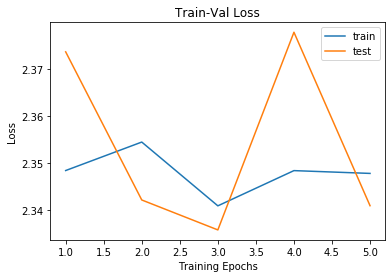

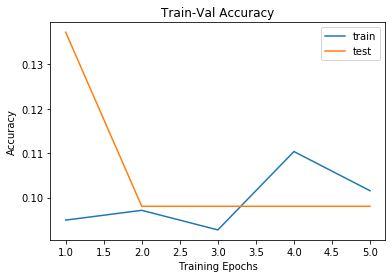

In [63]:
# plot loss and accuracies over epochs
trainutils.plot_loss(loss_hist, metric_hist)